## Libraries

In [3]:
import numpy as np
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
import matplotlib.pyplot as plt
import seaborn as sns

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

## Feature Engineering

In [9]:
import pandas as pd
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

train = pd.read_csv('child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("child-mind-institute-problematic-internet-use/series_test.parquet")
time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test_ids = test["id"]
test = test.drop('id', axis=1)

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 
          'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

"""This Mapping Works Fine For me I also Check Each Values in Train and test Using Logic. There no Data Lekage."""

for col in cat_c:
    mapping_train = create_mapping(col, train)
    mapping_test = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_test).astype(int)

print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')

# Save processed train and test datasets to CSV
train.to_csv('child-mind-institute-problematic-internet-use/processed_train.csv', index=False)
test.to_csv('child-mind-institute-problematic-internet-use/processed_test.csv', index=False)

print("Processed data saved to CSV!")


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 17.78it/s]


Train Shape : (2736, 155) || Test Shape : (20, 154)
Processed data saved to CSV!


## Handling missing values

In [11]:
import pandas as pd
from sklearn.impute import KNNImputer

# Assuming `train` and `test` are your dataframes
# Define features dynamically
num_features = [f for f in train.columns if train[f].dtype in ['float64', 'int64']]
cat_features = [f for f in train.columns if f not in num_features]

# Exclude 'sii' (target) column from numerical features
if 'sii' in num_features:
    num_features.remove('sii')

print('The number of numerical features:', len(num_features))
print('The number of categorical features:', len(cat_features))

# Ensure the test set has all numerical and categorical features from train
missing_numerical_in_test = [col for col in train.columns if col not in test.columns and col in num_features]
for col in missing_numerical_in_test:
    test[col] = None  # Add missing numerical columns with NaN values

missing_categorical_in_test = [col for col in train.columns if col not in test.columns and col in cat_features]
for col in missing_categorical_in_test:
    test[col] = 'unknown'  # Add missing categorical columns with placeholder values

# Impute numerical features for train
imputer_num = KNNImputer(n_neighbors=2, weights="uniform")
train[num_features] = imputer_num.fit_transform(train[num_features])  # Fit and transform on train

# Use the same imputer for test
test[num_features] = imputer_num.transform(test[num_features])  # Transform on test

# Handle categorical features for train
for col in cat_features:
    train[col] = train[col].fillna('unknown')  # Fill missing values with 'unknown'
    train[col] = train[col].astype('category')  # Convert to categorical

# Handle categorical features for test
for col in cat_features:
    test[col] = test[col].fillna('unknown')  # Fill missing values with 'unknown'
    test[col] = test[col].astype('category')  # Convert to categorical

# Verify missing values in both datasets
print("Train missing values after imputation:", train.isnull().sum().sum())
print("Test missing values after imputation:", test.isnull().sum().sum())


The number of numerical features: 154
The number of categorical features: 0
Train missing values after imputation: 0
Test missing values after imputation: 0


In [12]:
train.shape

(2736, 155)

In [13]:
test.shape

(20, 154)

## Class Distribution

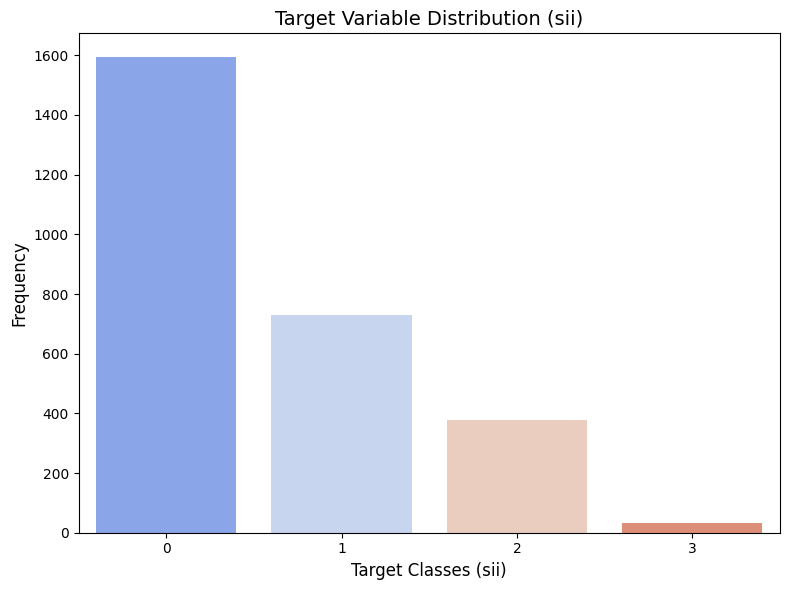

Target Class Distribution:
sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check target distribution in the training data
plt.figure(figsize=(8, 6))
sns.countplot(x=train['sii'], palette="coolwarm")
plt.title("Target Variable Distribution (sii)", fontsize=14)
plt.xlabel("Target Classes (sii)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=["0", "1", "2", "3"])
plt.tight_layout()
plt.show()

# Print exact counts of each class
print("Target Class Distribution:")
print(train['sii'].value_counts())


### MLPModel

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE
import numpy as np
import pandas as pd

# Define a simple MLP model
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return self.softmax(x)

# Split the dataset
X = train.drop(columns=["sii"])  # Features
y = train["sii"].astype(int)     # Target

# Split into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Function to train a single MLP model
def train_mlp(X_train, X_valid, y_train, y_valid, hidden_dim, epochs=50, batch_size=32, learning_rate=0.001):
    # Oversample with Borderline-SMOTE
    oversampler = BorderlineSMOTE(random_state=42)
    X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_valid_scaled = scaler.transform(X_valid)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_balanced.values, dtype=torch.long)
    y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.long)

    # Initialize the model
    input_dim = X_train_scaled.shape[1]
    output_dim = len(y_train.unique())
    model = MLPModel(input_dim, hidden_dim, output_dim)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    return model, scaler

# Define ensemble parameters
n_models = 5  # Number of models in the ensemble
hidden_dim = 64  # Hidden layer dimensions
random_seeds = [42, 100, 202, 300, 404]  # Random seeds for each model

# Train multiple MLP models
models = []
scalers = []

for i, seed in enumerate(random_seeds):
    print(f"\nTraining model {i+1}/{n_models} with seed {seed}")
    model, scaler = train_mlp(X_train, X_valid, y_train, y_valid, hidden_dim)
    models.append(model)
    scalers.append(scaler)

# Ensemble predictions
def ensemble_predictions(models, scalers, X_valid, weights=None):
    weights = weights if weights else [1] * len(models)  # Default weights to 1
    predictions = []
    for i, (model, scaler) in enumerate(zip(models, scalers)):
        X_valid_scaled = scaler.transform(X_valid)
        X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float32)
        model.eval()
        with torch.no_grad():
            pred = model(X_valid_tensor).argmax(dim=1)
        predictions.append(weights[i] * pred.numpy())
    return np.round(np.sum(predictions, axis=0) / sum(weights)).astype(int)

# Validate ensemble model
y_val_pred_ensemble = ensemble_predictions(models, scalers, X_valid)

# Evaluate Performance
mse = mean_squared_error(y_valid, y_val_pred_ensemble)
precision = precision_score(y_valid, y_val_pred_ensemble, average='weighted')
recall = recall_score(y_valid, y_val_pred_ensemble, average='weighted')
f1 = f1_score(y_valid, y_val_pred_ensemble, average='weighted')

# Define Quadratic Weighted Kappa (QWK)
def quadratic_weighted_kappa(y_true, y_pred, num_classes):
    O = np.zeros((num_classes, num_classes), dtype=np.float32)
    for a, p in zip(y_true, y_pred):
        O[int(a), int(p)] += 1
    W = np.zeros((num_classes, num_classes), dtype=np.float32)
    for i in range(num_classes):
        for j in range(num_classes):
            W[i, j] = ((i - j) ** 2) / ((num_classes - 1) ** 2)
    actual_hist = np.sum(O, axis=1)
    pred_hist = np.sum(O, axis=0)
    E = np.outer(actual_hist, pred_hist) / np.sum(O)
    numerator = np.sum(W * O)
    denominator = np.sum(W * E)
    return 1 - (numerator / denominator)

qwk_val = quadratic_weighted_kappa(y_valid, y_val_pred_ensemble, num_classes=4)

# Print Results
print(f"Validation MSE: {mse:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Quadratic Weighted Kappa (QWK): {qwk_val:.4f}")

# Test predictions and submission
test_scaled = scalers[0].transform(test)  # Use the first scaler to scale test data
test_predictions = ensemble_predictions(models, scalers, test)  # Use ensemble predictions

# Create a submission DataFrame
submission = pd.DataFrame({
    "id": test_ids,  # Replace `test_ids` with the appropriate column containing test sample IDs
    "sii": test_predictions
})

# Save the submission file
submission.to_csv("submission.csv", index=False)
print("Submission file saved as 'submission.csv'")
print(submission.head())


Training model 1/5 with seed 42
Epoch [10/50], Loss: 1.3157
Epoch [20/50], Loss: 1.2109
Epoch [30/50], Loss: 1.1562
Epoch [40/50], Loss: 1.1135
Epoch [50/50], Loss: 1.0761

Training model 2/5 with seed 100
Epoch [10/50], Loss: 1.3335
Epoch [20/50], Loss: 1.2367
Epoch [30/50], Loss: 1.1683
Epoch [40/50], Loss: 1.1232
Epoch [50/50], Loss: 1.0803

Training model 3/5 with seed 202
Epoch [10/50], Loss: 1.3279
Epoch [20/50], Loss: 1.2225
Epoch [30/50], Loss: 1.1720
Epoch [40/50], Loss: 1.1344
Epoch [50/50], Loss: 1.0995

Training model 4/5 with seed 300
Epoch [10/50], Loss: 1.3199
Epoch [20/50], Loss: 1.2146
Epoch [30/50], Loss: 1.1562
Epoch [40/50], Loss: 1.1138
Epoch [50/50], Loss: 1.0754

Training model 5/5 with seed 404
Epoch [10/50], Loss: 1.3154
Epoch [20/50], Loss: 1.2237
Epoch [30/50], Loss: 1.1757
Epoch [40/50], Loss: 1.1322
Epoch [50/50], Loss: 1.0945
Validation MSE: 0.9398
Precision: 0.5688
Recall: 0.5255
F1 Score: 0.5393
Quadratic Weighted Kappa (QWK): 0.3694
Submission file sav

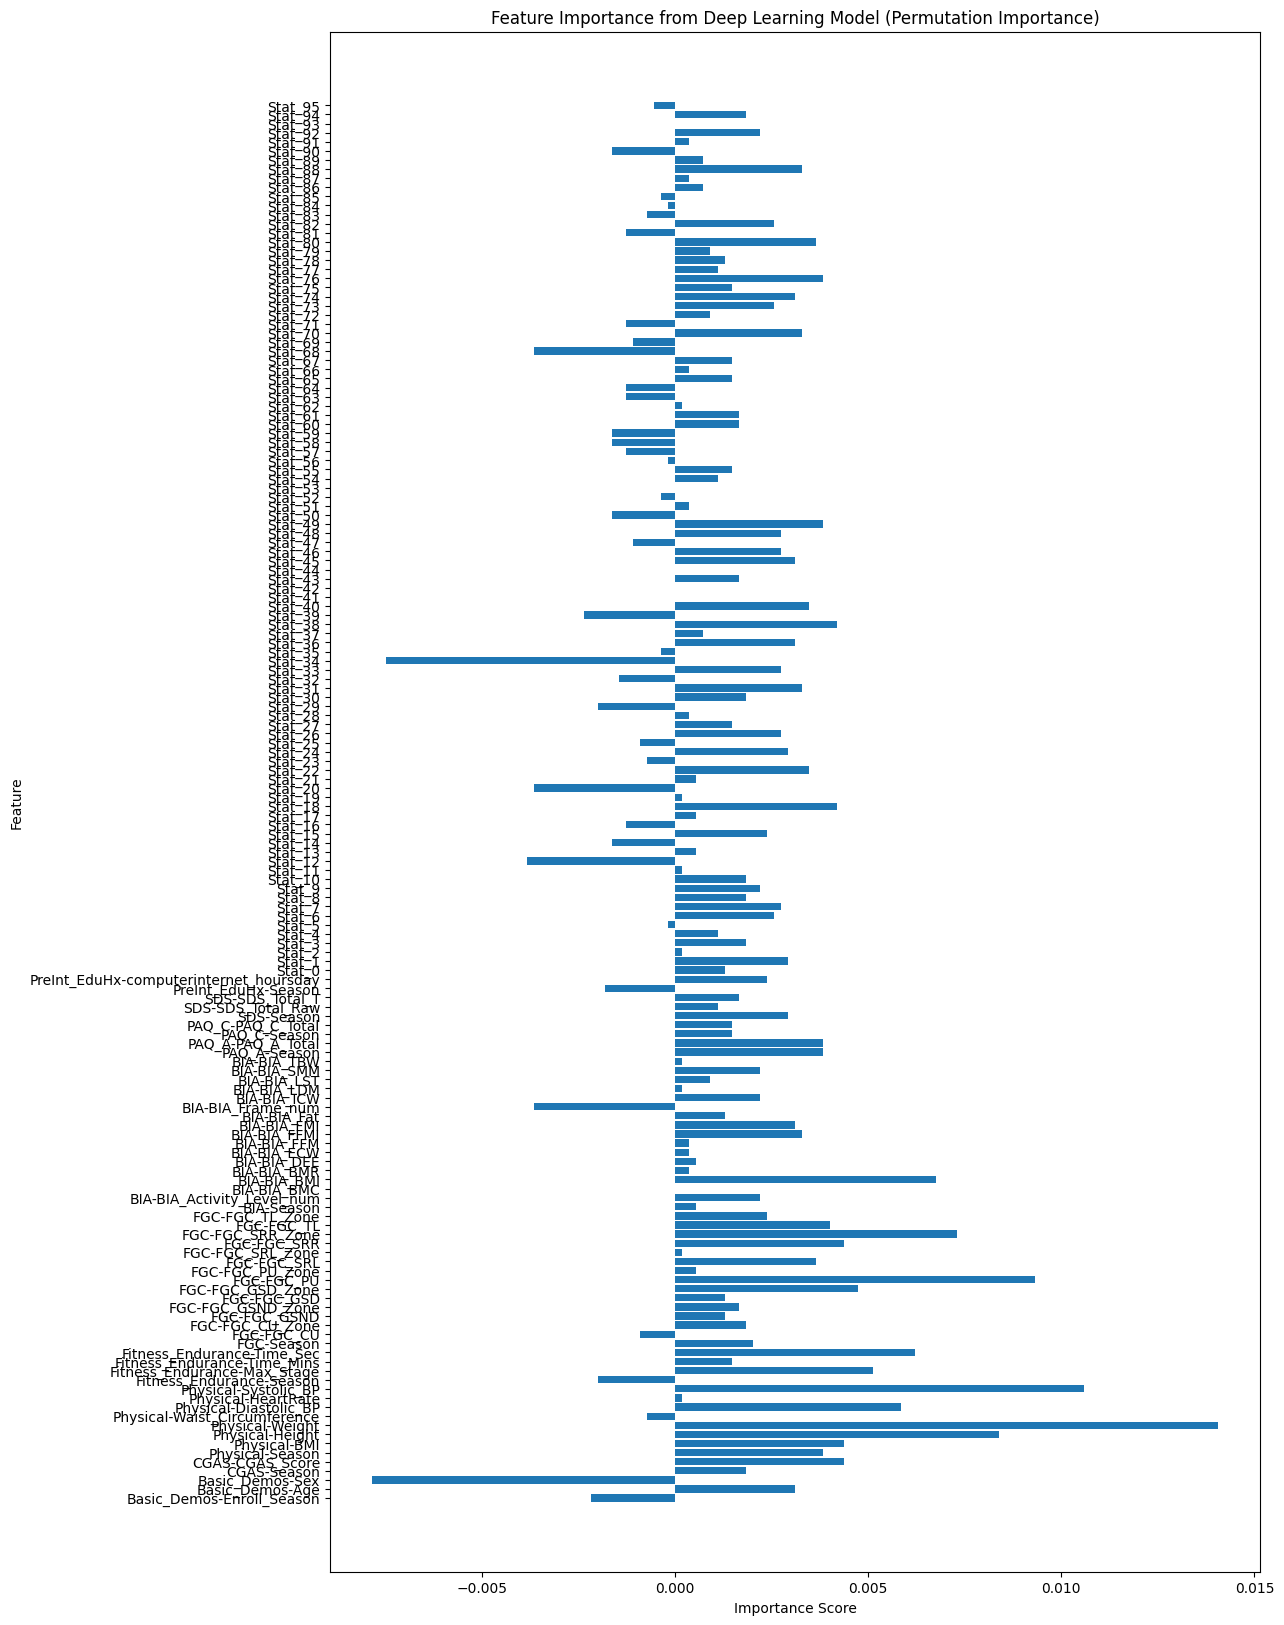

In [31]:
import torch
import torch.nn as nn
from sklearn.base import BaseEstimator
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Define a wrapper for the PyTorch model to make it compatible with scikit-learn
class MLPModelWrapper(BaseEstimator):
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler

    def fit(self, X, y=None):
        # PyTorch models are trained externally, so we do not need to train here
        return self

    def predict(self, X):
        # Convert the input data to the correct format for PyTorch
        X_tensor = torch.tensor(X, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(X_tensor).argmax(dim=1).numpy()  # Get class with highest probability
        return y_pred

    def score(self, X, y):
        # Custom score function that calculates accuracy
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

# Assuming 'models[0]' is the trained PyTorch model and 'scalers[0]' is the scaler for that model
model = models[0]
scaler = scalers[0]

# Wrap the model with the MLPModelWrapper
wrapped_model = MLPModelWrapper(model, scaler)

# Calculate permutation importance using the wrapped model
perm_importance = permutation_importance(wrapped_model, X_valid_scaled, y_valid, n_repeats=10, random_state=42, n_jobs=-1, scoring='accuracy')

# Plot feature importance
importance = perm_importance.importances_mean  # Mean of the feature importance across all permutations
plt.figure(figsize=(12, 20))
plt.barh(X.columns, importance)
plt.title('Feature Importance from Deep Learning Model (Permutation Importance)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

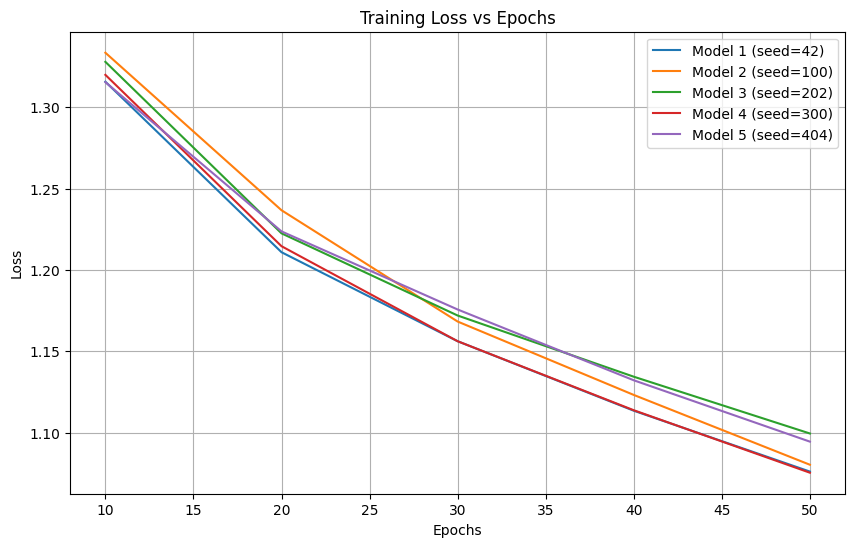

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Data for each model training
epochs = np.arange(10, 51, 10)
loss_model_1 = [1.3157, 1.2109, 1.1562, 1.1135, 1.0761]
loss_model_2 = [1.3335, 1.2367, 1.1683, 1.1232, 1.0803]
loss_model_3 = [1.3279, 1.2225, 1.1720, 1.1344, 1.0995]
loss_model_4 = [1.3199, 1.2146, 1.1562, 1.1138, 1.0754]
loss_model_5 = [1.3154, 1.2237, 1.1757, 1.1322, 1.0945]

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_model_1, label='Model 1 (seed=42)')
plt.plot(epochs, loss_model_2, label='Model 2 (seed=100)')
plt.plot(epochs, loss_model_3, label='Model 3 (seed=202)')
plt.plot(epochs, loss_model_4, label='Model 4 (seed=300)')
plt.plot(epochs, loss_model_5, label='Model 5 (seed=404)')

plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Performance Metrics

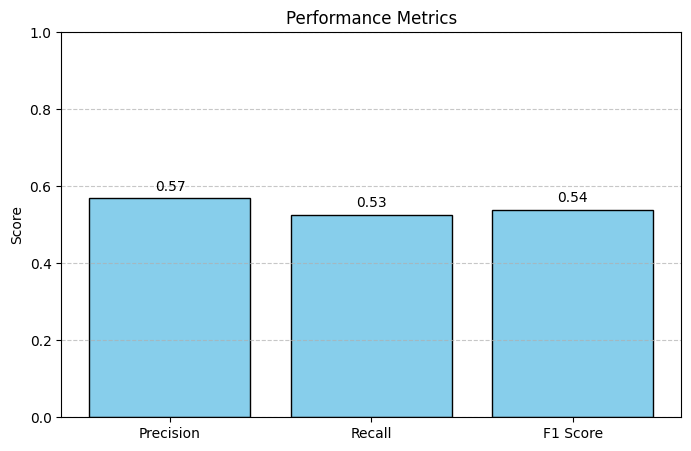

In [38]:
# Metrics data
metrics = ['Precision', 'Recall', 'F1 Score']
values = [0.5688, 0.5255, 0.5393]

# Plotting the metrics
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color='skyblue', edgecolor='black')
plt.ylim(0, 1)
plt.title('Performance Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotating the bars with their values
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.show()